<a href="https://colab.research.google.com/github/Md-Faisal-Sheikh/SVHN_ResNet34_VGG16_Implementation_-_Comparison.ipynb/blob/main/SVHN_Implementation_%26_Comparison_using_ResNet34_%26_VGG16_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Library Imports**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Plotting style
sns.set_style("whitegrid")

**Calculate Dataset Mean and Standard Deviation**

In [ ]:
def calculate_normalization_stats(data_dir='./data'):
    print("Calculating dataset mean and standard deviation...")

    # Load dataset
    dataset = datasets.SVHN(root=data_dir, split='train', download=True,
                            transform=transforms.ToTensor())
    loader = torch.utils.data.DataLoader(dataset, batch_size=2048, shuffle=False, num_workers=2)

    mean = 0.
    std = 0.
    nb_samples = 0.

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1) # Flatten image pixels

        # Accumulate sum and sum of squares
        mean += data.mean(2).sum(0)
        std += (data ** 2).mean(2).sum(0)

        nb_samples += batch_samples

    # Final calculations
    mean /= nb_samples
    std /= nb_samples

    std = torch.sqrt(std - mean ** 2)

    print(f"Calculated Mean: {mean.tolist()}")
    print(f"Calculated Std:  {std.tolist()}")
    return mean.tolist(), std.tolist()

svhn_mean, svhn_std = calculate_normalization_stats()

Calculating dataset mean and standard deviation...


100%|██████████| 182M/182M [00:16<00:00, 10.9MB/s]


Calculated Mean: [0.4376821517944336, 0.4437696933746338, 0.47280436754226685]
Calculated Std:  [0.19803006947040558, 0.20101578533649445, 0.1970362365245819]


**Data Loader**

In [ ]:
def data_loader(data_dir,
                batch_size,
                mean, std,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):

    normalize = transforms.Normalize(mean=mean, std=std)

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])

    if test:
        dataset = datasets.SVHN(
            root=data_dir, split='test',
            download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle,
            num_workers=4, pin_memory=True
        )

        return data_loader

    train_dataset = datasets.SVHN(
        root=data_dir, split='train',
        download=True, transform=transform,
    )

    valid_dataset = datasets.SVHN(
        root=data_dir, split='train',
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=4, pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=4, pin_memory=True)

    return (train_loader, valid_loader)

# Load Data using the calculated stats
train_loader, valid_loader = data_loader(data_dir='./data', batch_size=256, mean=svhn_mean, std=svhn_std)
test_loader = data_loader(data_dir='./data', batch_size=256, mean=svhn_mean, std=svhn_std, test=True)

100%|██████████| 64.3M/64.3M [00:10<00:00, 5.87MB/s]


**Model Training and Evaluation**

In [ ]:
def train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, model_name="Model", scheduler=None):
    history = { 'train_loss': [], 'valid_acc': [] }

    print(f"Starting training for {model_name}...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation Phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs

        val_acc = 100 * correct / total
        history['valid_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if scheduler is not None:
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Learning Rate: {current_lr:.6f}")

    return history

**ResidualBlock and ResNet34 Model**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

**VGG16 Model**

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            # Layer 2
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            # Layer 4
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            # Layer 6
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            # Layer 7
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 8
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            # Layer 9
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            # Layer 10
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 11
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            # Layer 12
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            # Layer 13
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

**Model Initialization and Training Setup**

In [ ]:
num_classes = 10

# Initialize Models
resnet_model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes).to(device)
vgg_model = VGG16(num_classes).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# ResNet34
num_epochs_resnet = 30

resnet_optimizer = torch.optim.SGD(
    resnet_model.parameters(),
    lr=0.01,
    weight_decay=1e-4,
    momentum=0.9
)

resnet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    resnet_optimizer,
    T_max=30,
    eta_min=1e-5
)

# VGG16
num_epochs_vgg = 40

vgg_optimizer = torch.optim.SGD(
    vgg_model.parameters(),
    lr=0.01,
    weight_decay=1e-4,
    momentum=0.9
)

vgg_scheduler = torch.optim.lr_scheduler.StepLR(
    vgg_optimizer,
    step_size=15,
    gamma=0.1
)

# Training ResNet34
print("Training ResNet34 ...")

resnet_history = train_and_evaluate(
    resnet_model,
    train_loader,
    valid_loader,
    criterion,
    resnet_optimizer,
    num_epochs_resnet,
    device,
    "ResNet34",
    scheduler=resnet_scheduler
)

# Training VGG16
print("Training VGG16 ...")

vgg_history = train_and_evaluate(
    vgg_model,
    train_loader,
    valid_loader,
    criterion,
    vgg_optimizer,
    num_epochs_vgg,
    device,
    "VGG16",
    scheduler=vgg_scheduler
)

Training ResNet34 ...
Starting training for ResNet34...
Epoch [1/30] | Loss: 0.9014 | Val Acc: 86.13%
  Learning Rate: 0.009973
Epoch [2/30] | Loss: 0.2438 | Val Acc: 88.81%
  Learning Rate: 0.009891
Epoch [3/30] | Loss: 0.1760 | Val Acc: 92.85%
  Learning Rate: 0.009756
Epoch [4/30] | Loss: 0.1369 | Val Acc: 90.81%
  Learning Rate: 0.009568
Epoch [5/30] | Loss: 0.0988 | Val Acc: 92.45%
  Learning Rate: 0.009331
Epoch [6/30] | Loss: 0.0649 | Val Acc: 88.30%
  Learning Rate: 0.009046
Epoch [7/30] | Loss: 0.0426 | Val Acc: 90.14%
  Learning Rate: 0.008717
Epoch [8/30] | Loss: 0.0255 | Val Acc: 90.95%
  Learning Rate: 0.008347
Epoch [9/30] | Loss: 0.0108 | Val Acc: 94.32%
  Learning Rate: 0.007941
Epoch [10/30] | Loss: 0.0048 | Val Acc: 94.55%
  Learning Rate: 0.007503
Epoch [11/30] | Loss: 0.0015 | Val Acc: 95.09%
  Learning Rate: 0.007037
Epoch [12/30] | Loss: 0.0007 | Val Acc: 95.32%
  Learning Rate: 0.006549
Epoch [13/30] | Loss: 0.0006 | Val Acc: 95.24%
  Learning Rate: 0.006044
Epoc

**Training Loss and Validation Accuracy Plotting**

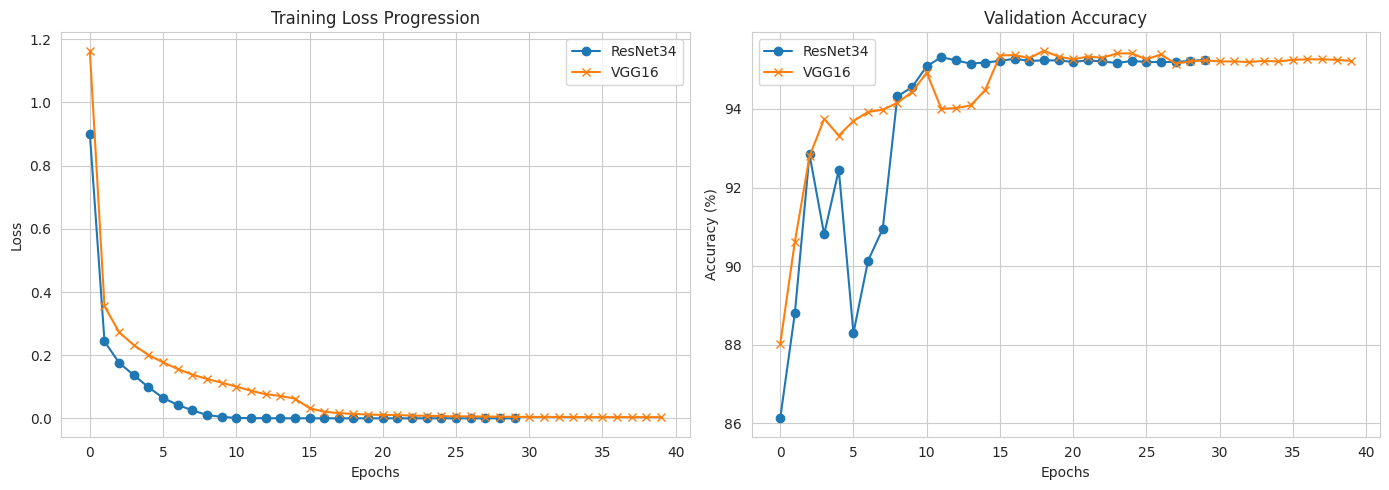

In [ ]:
plt.figure(figsize=(14, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(resnet_history['train_loss'], label='ResNet34', marker='o')
plt.plot(vgg_history['train_loss'], label='VGG16', marker='x')
plt.title('Training Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(resnet_history['valid_acc'], label='ResNet34', marker='o')
plt.plot(vgg_history['valid_acc'], label='VGG16', marker='x')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

**Model Predictions and Confusion Matrix Plotting**

--- ResNet34 Report ---
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1744
           1       0.96      0.97      0.97      5099
           2       0.97      0.97      0.97      4149
           3       0.95      0.93      0.94      2882
           4       0.97      0.96      0.96      2523
           5       0.97      0.95      0.96      2384
           6       0.94      0.96      0.95      1977
           7       0.96      0.95      0.95      2019
           8       0.95      0.93      0.94      1660
           9       0.91      0.94      0.92      1595

    accuracy                           0.96     26032
   macro avg       0.95      0.95      0.95     26032
weighted avg       0.96      0.96      0.96     26032



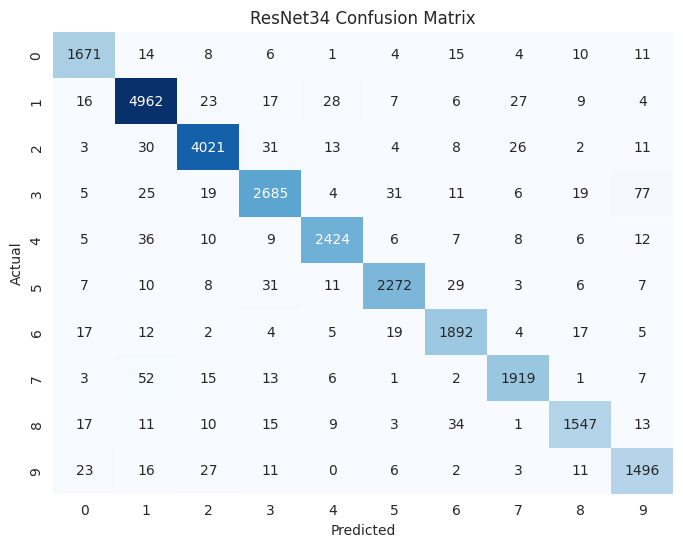

--- VGG16 Report ---
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1744
           1       0.96      0.97      0.96      5099
           2       0.97      0.97      0.97      4149
           3       0.95      0.94      0.94      2882
           4       0.97      0.96      0.96      2523
           5       0.96      0.95      0.96      2384
           6       0.95      0.95      0.95      1977
           7       0.95      0.95      0.95      2019
           8       0.96      0.93      0.94      1660
           9       0.91      0.95      0.93      1595

    accuracy                           0.96     26032
   macro avg       0.95      0.95      0.95     26032
weighted avg       0.96      0.96      0.96     26032



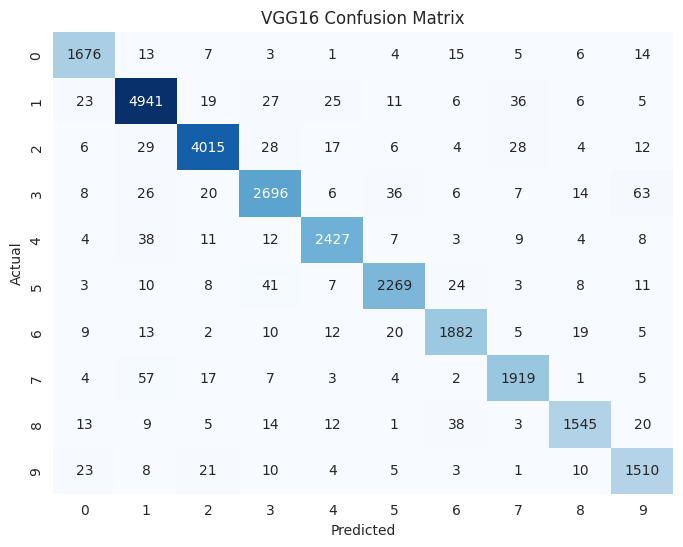

In [ ]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            del images, labels, outputs
    return all_labels, all_preds

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ResNet Metrics
y_true, y_pred = get_predictions(resnet_model, test_loader, device)
print(f"--- ResNet34 Report ---")
print(classification_report(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred, "ResNet34")

# VGG Metrics
y_true, y_pred = get_predictions(vgg_model, test_loader, device)
print(f"--- VGG16 Report ---")
print(classification_report(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred, "VGG16")

**Visualize Model Predictions on Test Images**

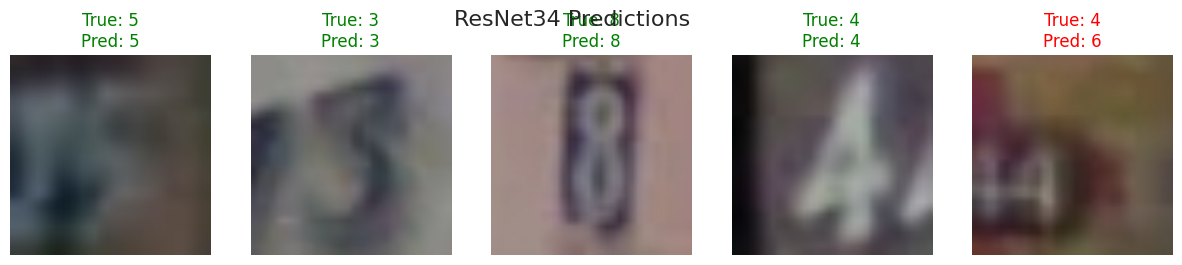

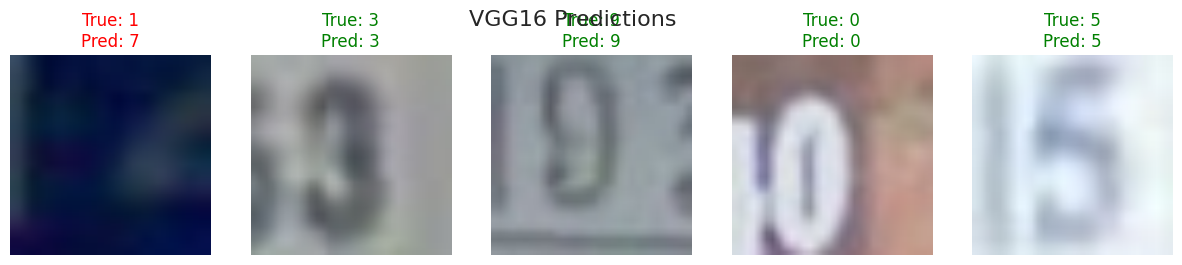

In [ ]:
def visualize_predictions(model, loader, device, model_name, mean, std, num_images=5):
    model.eval()
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(f'{model_name} Predictions', fontsize=16)

    # Denormalize
    mean_t = torch.tensor(mean).view(3, 1, 1).to(device)
    std_t = torch.tensor(std).view(3, 1, 1).to(device)

    for i in range(num_images):
        img = images[i] * std_t + mean_t # Un-normalize
        img = img.cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {labels[i].item()}\nPred: {preds[i].item()}",
                          color=("green" if preds[i]==labels[i] else "red"))
        axes[i].axis('off')
    plt.show()

visualize_predictions(resnet_model, test_loader, device, "ResNet34", svhn_mean, svhn_std)
visualize_predictions(vgg_model, test_loader, device, "VGG16", svhn_mean, svhn_std)

**Saving Models**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(resnet_model.state_dict(), "/content/drive/MyDrive/resnet34_svhn.pth")
torch.save(vgg_model.state_dict(), "/content/drive/MyDrive/vgg16_svhn.pth")
print("Models saved.")

Mounted at /content/drive
Models saved.


**Single Image Prediction and Inference**

Running Inference...

[ResNet34] Prediction: Class 0 | Confidence: 100.00%


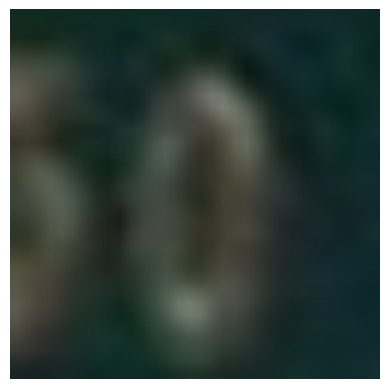

In [ ]:
def predict_single_image(image_path, model, model_name, device, mean, std):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            probs = torch.nn.functional.softmax(output[0], dim=0)
            _, pred = torch.max(output, 1)

        print(f"\n[{model_name}] Prediction: Class {pred.item()} | Confidence: {probs[pred].item()*100:.2f}%")

        # Display image
        if model_name == "ResNet34":
            plt.imshow(image)
            plt.axis('off')
            plt.show()
    except Exception as e:
        print(f"Error: {e}")

from torchvision.utils import save_image
sample_img_t, _ = next(iter(valid_loader))
# Inverse normalize for saving
inv_mean = [-m/s for m, s in zip(svhn_mean, svhn_std)]
inv_std = [1/s for s in svhn_std]
inv_trans = transforms.Normalize(mean=inv_mean, std=inv_std)
save_image(inv_trans(sample_img_t[0]), "test_sample.png")

# Run Inference for Both
print("Running Inference...")
predict_single_image("test_sample.png", resnet_model, "ResNet34", device, svhn_mean, svhn_std)
# predict_single_image("test_sample.png", vgg_model, "VGG16", device, svhn_mean, svhn_std)